# Section 4.3 — Interpreting linear models

This notebook contains the code examples from [Section 4.3 Interpreting linear models]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (8, 5)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/interpreting"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

In [4]:
import statsmodels.formula.api as smf

## Definitions

In [5]:
doctors = pd.read_csv("../datasets/doctors.csv")
n = doctors.shape[0]

lm2 = smf.ols('score ~ 1 + alc + weed + exrc', data=doctors).fit()

# the coefficients of the best-fit line
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     270.3
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           1.05e-60
Time:                        15:25:12   Log-Likelihood:                -547.63
No. Observations:                 156   AIC:                             1103.
Df Residuals:                     152   BIC:                             1115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.4529      1.289     46.885      0.000      57.905      63.000
alc           -1.8001      0.070    -25.726      0.000      -1.938      -1.662
weed          -1.0216      0.476     -2.145      0.034      -1.962      -0.081
exrc           1.7683      0.138     12.809      0.000       1.496       2.041
==============================================================================
Omnibus:                        1.140   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.900
Skew:                           0.182   Prob(JB):                        0.638
Kurtosis:                       3.075   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model fit metrics

In [6]:
lm2.rsquared

0.8421649167873537

In [7]:
lm2.rsquared_adj

0.8390497506713147

In [8]:
# Explained sum of squares
lm2.ess

54570.51590209804

In [9]:
lm2.ssr / n

65.56013803717559

### Metrics 

In [10]:
scores = doctors["score"].values
scoreshat = lm2.fittedvalues.values
meanscore = np.mean(scores)

tss = sum( (scores-meanscore)**2 )

In [11]:
# R^2 alt.
lm2.rsquared, lm2.rsquared, 1-lm2.ssr/tss, lm2.ess/tss

(0.8421649167873537,
 0.8421649167873537,
 0.8421649167873536,
 0.8421649167873542)

In [12]:
lm2.llf

-547.6259042117637

In [13]:
lm2.aic, lm2.bic

(1103.2518084235273, 1115.4512324525256)

### Other metrics (optional material)

In [14]:
# TSS = Total Sum of Squares
tss = sum( (scores-meanscore)**2 )
lm2.centered_tss, tss

(64797.89743589744, 64797.8974358974)

In [15]:
# SSR = Sum of Squares Residuals
ssr = sum( (scores-scoreshat)**2 )
ssr, lm2.ssr

(10227.381533799391, 10227.381533799393)

In [16]:
# ESS = Explained Sum of Squares
ess = sum( (scoreshat-meanscore)**2 ) 
lm2.ess, ess

(54570.51590209804, 54570.515902097904)

In [17]:
# MSE
from statsmodels.tools.eval_measures import mse
mse(scores, scoreshat), lm2.ssr/n

(65.56013803717558, 65.56013803717559)

In [18]:
# RMSE
from statsmodels.tools.eval_measures import rmse

rmse(scores, scoreshat), np.sqrt(lm2.ssr/n)

(8.096921516056307, 8.096921516056309)

In [19]:
# MAE
from statsmodels.tools.eval_measures import meanabs

mae = sum( np.abs(scores - scoreshat) ) / n
meanabs(scores, scoreshat), mae

(6.41593242149194, 6.415932421491938)

In [20]:
# MAPE (cuttable)
mape = sum( np.abs(scores - scoreshat)/scores ) / n
mape

0.22234476956901394

In [21]:
# Mean squared error the model
# The explained sum of squares divided by the model degrees of freedom
lm2.mse_model, lm2.ess/3

(18190.171967366015, 18190.171967366015)

In [22]:
# Mean squared error of the residuals
# The sum of squared residuals divided by the residual degrees of freedom.
lm2.mse_resid, lm2.ssr/(n-4)

(67.28540482762759, 67.28540482762759)

In [23]:
# Total mean squared error
# The centered total sum of squares divided by the number of observations.
lm2.mse_total, lm2.centered_tss/(n-1)

(418.05095119933833, 418.05095119933833)

## Parameter estimates

In [24]:
# estimated parameters
lm2.params

Intercept    60.452901
alc          -1.800101
weed         -1.021552
exrc          1.768289
dtype: float64

In [25]:
# estimated sigma (noise term)
np.sqrt(lm2.scale)

8.202768119825624

## Confidence intervals for model parameters

In [26]:
# standard errors
lm2.bse

Intercept    1.289380
alc          0.069973
weed         0.476166
exrc         0.138056
dtype: float64

In [27]:
lm2.conf_int(alpha=0.05)

,0,1
Intercept,57.905480,63.000321
alc,-1.938347,-1.661856
weed,-1.962309,-0.080794
exrc,1.495533,2.041044


## Hypothesis testing for linear models

### F-test for the overall model

In [28]:
lm2.fvalue, lm2.f_pvalue

(270.34350189265825, 1.0512133413867047e-60)

### T-tests for individual parameters

Hypothesis testing for slope coefficient

Is there a non-zero slope coefficient?


- **null hypothesis $H_0$**: `alc` has no effect on `score`,
  which is equivalent to $\beta_{\texttt{alc}} = 0$:
  $$ \large
     H_0: \qquad
     \textrm{score}
     \sim \mathcal{N}(
         {\color{red}
             \beta_0
              + \beta_{\texttt{weed}}\!\cdot\!\textrm{weed}
              + \beta_{\texttt{exrc}}\!\cdot\!\textrm{exrc}
          }, \ \sigma) \qquad \qquad 
  $$

- **alternative hypothesis $H_A$**: `alc` has an effect on `score`,
  and the slope is not zero, $\beta_{\texttt{alc}} \neq 0$:
  $$ \large
     H_A: \qquad
     \textrm{score} 
     \sim \mathcal{N}\left(
          {\color{blue}
             \beta_0
              + \beta_{\texttt{alc}}\!\cdot\!\textrm{alc}
              + \beta_{\texttt{weed}}\!\cdot\!\textrm{weed}
              + \beta_{\texttt{exrc}}\!\cdot\!\textrm{exrc}
          }, \ \sigma \right)
  $$

In [29]:
lm2.tvalues["alc"]

-25.72565391310632

In [30]:
lm2.pvalues["alc"]

2.985012588756153e-57

In [31]:
# to reproduce `alc` p-value
from scipy.stats import t as tdist
obst_alc = lm2.tvalues["alc"]
pleft = tdist(df=lm2.df_resid).cdf(obst_alc)
pright = 1 - tdist(df=lm2.df_resid).cdf(obst_alc)
pvalue = 2 * min(pleft, pright)
pvalue

2.985012588756153e-57

#### Other t-values and p-values

In [32]:
lm2.tvalues

Intercept    46.885245
alc         -25.725654
weed         -2.145371
exrc         12.808529
dtype: float64

In [33]:
lm2.df_resid

152.0

In [34]:
lm2.pvalues

Intercept    2.756807e-92
alc          2.985013e-57
weed         3.351156e-02
exrc         6.136296e-26
dtype: float64

## Assumptions checks and diagnostics

### Diagnostics plots

### Linearity checks

/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


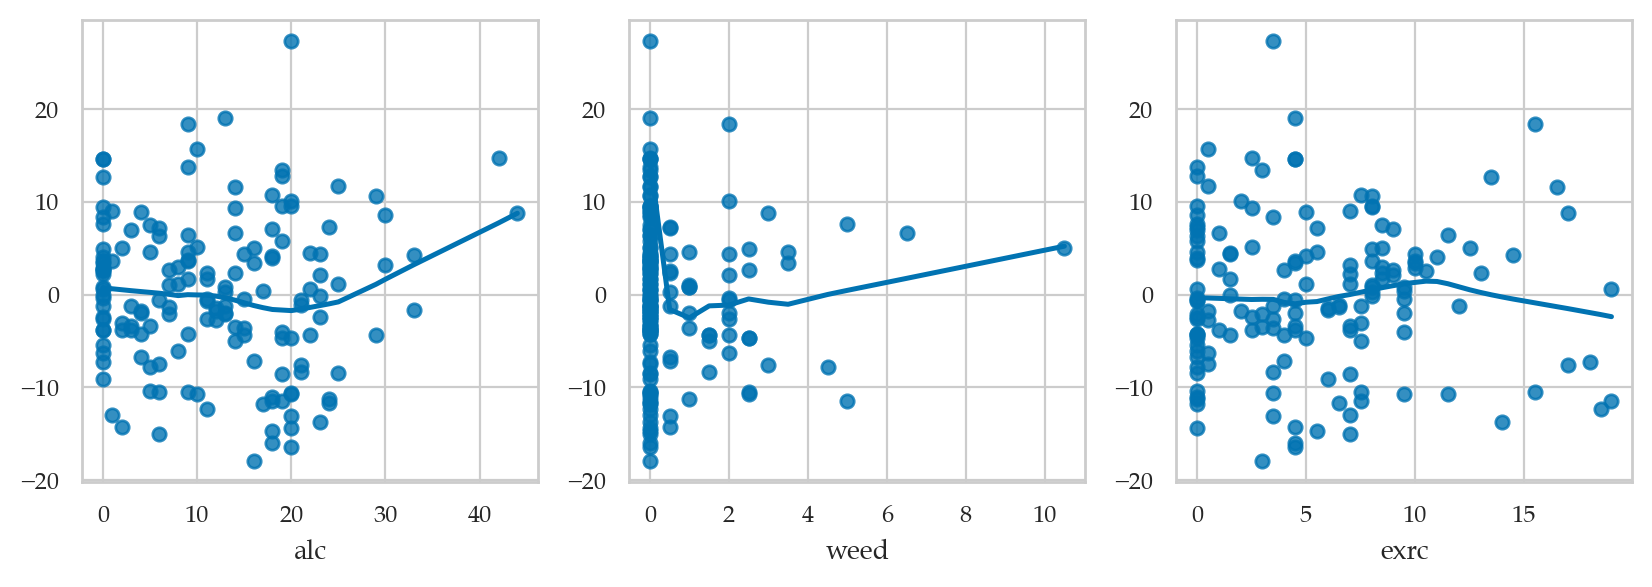

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
sns.regplot(x=doctors["alc"],  y=lm2.resid, lowess=True, ax=axs[0])
sns.regplot(x=doctors["weed"], y=lm2.resid, lowess=True, ax=axs[1])
sns.regplot(x=doctors["exrc"], y=lm2.resid, lowess=True, ax=axs[2]);

### Normality checks

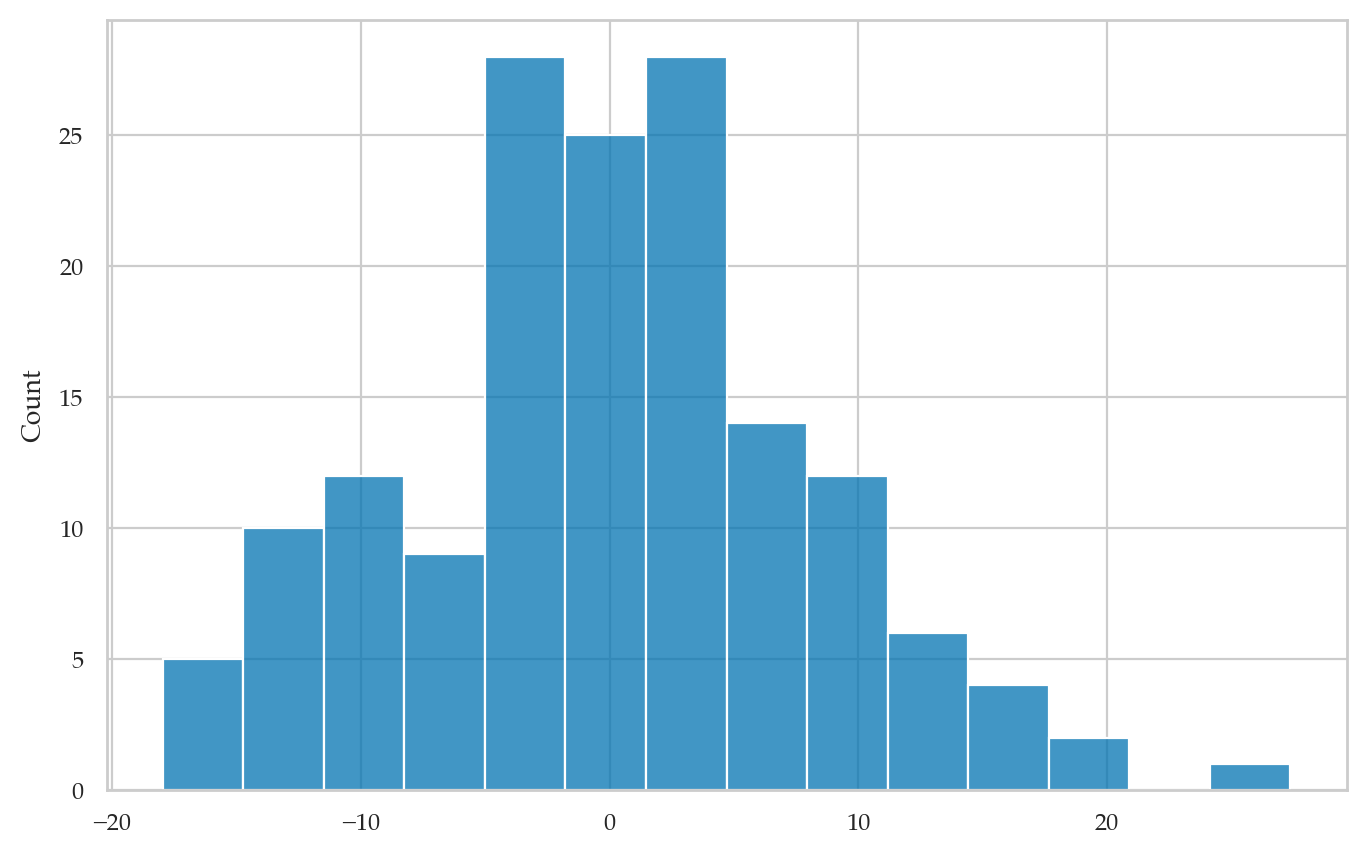

In [36]:
sns.histplot(lm2.resid);

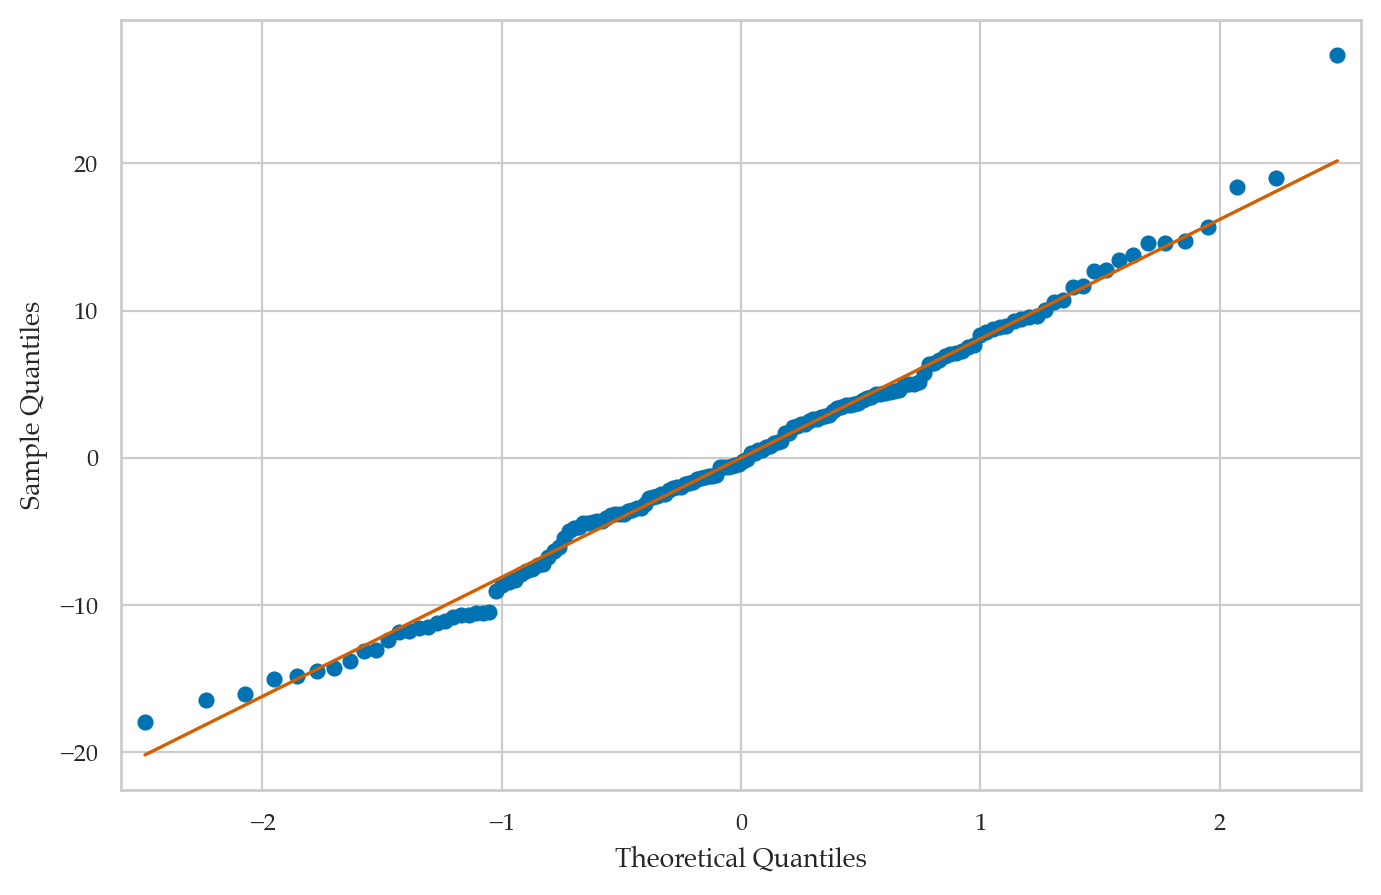

In [37]:
from statsmodels.graphics.api import qqplot

qqplot(lm2.resid, line="s");

### Homoscedasticity checks

via https://ethanweed.github.io/pythonbook/05.04-regression.html#checking-the-homogeneity-of-variance

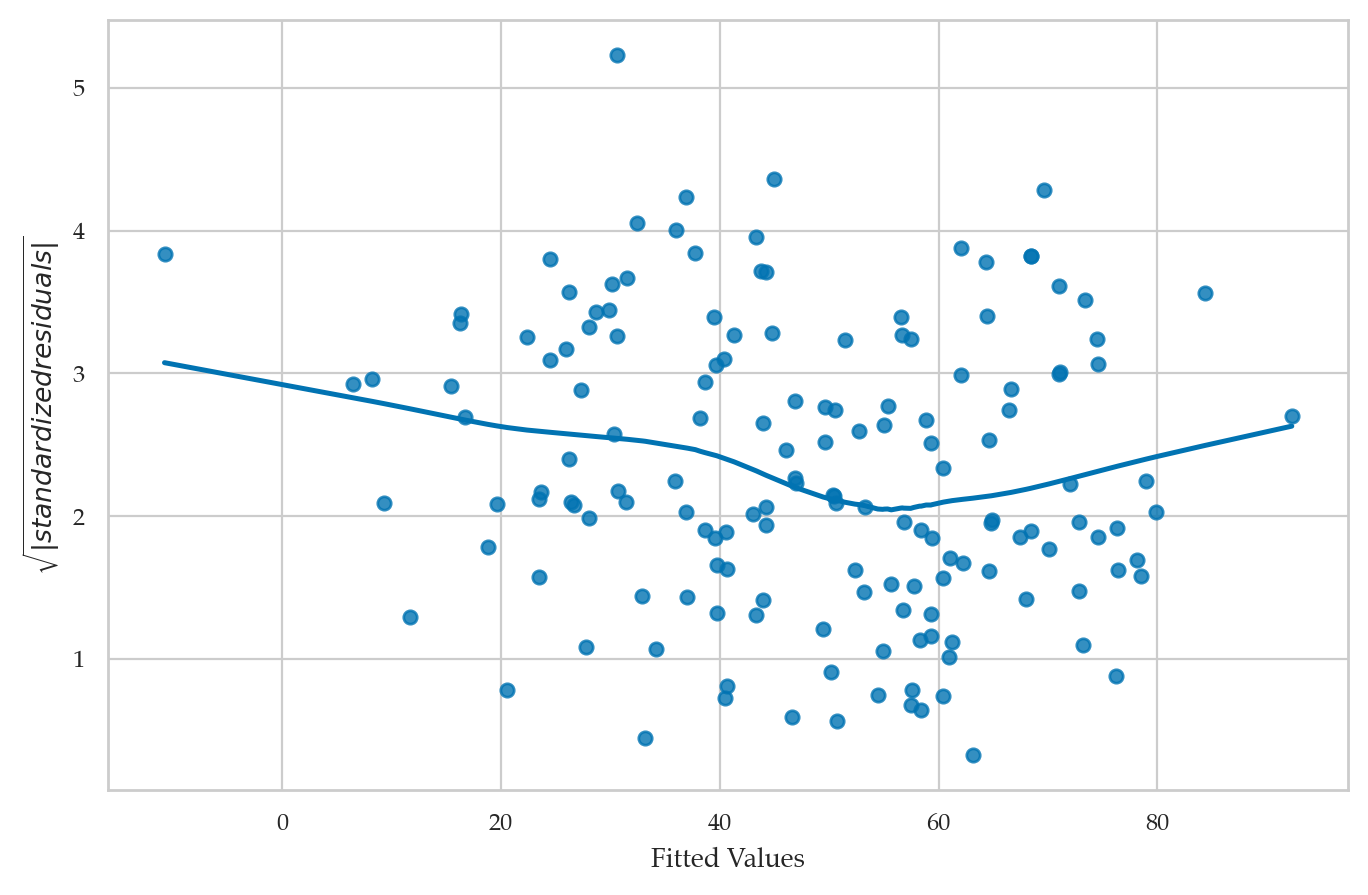

In [38]:
df_slplot = pd.DataFrame(
    {'fitted': lm2.fittedvalues,
     'sqrt_abs_stand_res': np.sqrt(np.abs(lm2.resid))})

ax = sns.regplot(data=df_slplot, x='fitted', y='sqrt_abs_stand_res', lowess=True)

ax.set_ylabel(r'$\sqrt{|standardized residuals|}$')
ax.set_xlabel('Fitted Values');

### Independence checks

### Collinearity checks

In [39]:
def variance_inflation_factor(exog, exog_idx):
    """
    exog : ndarray, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression
    exog_idx : int
        index of the exogenous variable in the columns of exog
    """
    k_vars = exog.shape[1]
    x_i = exog[:, exog_idx]
    mask = np.arange(k_vars) != exog_idx
    x_noti = exog[:, mask]
    r_squared_i = OLS(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i)
    return vif

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for i, name in enumerate(lm2.model.exog_names):
    vifi = variance_inflation_factor(lm2.model.exog, i)
    print("VIF for", name, "=", vifi)


VIF for Intercept = 3.854478605601843
VIF for alc = 1.0026692156304757
VIF for weed = 1.010703145007322
VIF for exrc = 1.010048809433661


In [41]:
doctors[["alc", "weed", "exrc"]].corr()

,alc,weed,exrc
alc,1.000000,0.042158,0.033625
weed,0.042158,1.000000,0.095239
exrc,0.033625,0.095239,1.000000


## Outliers and influential observations

In [42]:
# regular residuals
lm2.resid

0       7.654858
1     -16.408174
2     -13.030821
3      -1.789073
4     -10.514154
         ...    
151     7.132895
152    -4.049719
153     2.271540
154    18.382639
155     2.864212
Length: 156, dtype: float64

In [43]:
infl2 = lm2.get_influence()
infl2.summary_frame()

,dfb_Intercept,dfb_alc,dfb_weed,dfb_exrc,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.116394,-0.111597,0.274526,-0.114981,0.025261,0.980976,0.095024,0.317875,0.980853,0.317836
1,-0.023456,-0.146355,0.077369,0.027821,0.013315,-2.013418,0.012967,-0.230777,-2.034092,-0.233147
2,-0.144254,0.149222,0.057507,-0.054123,0.011166,-1.602346,0.017098,-0.211335,-1.610728,-0.212441
3,-0.026064,0.014067,0.006287,0.011386,0.000180,-0.219722,0.014655,-0.026796,-0.219033,-0.026712
4,-0.054777,0.030947,0.050412,-0.051499,0.004112,-1.288119,0.009816,-0.128254,-1.290940,-0.128535
...,...,...,...,...,...,...,...,...,...,...
151,0.062777,-0.043468,-0.004970,0.003569,0.001719,0.873481,0.008930,0.082914,0.872796,0.082849
152,0.014217,-0.030273,0.022718,-0.035467,0.001050,-0.497866,0.016658,-0.064799,-0.496630,-0.064638
153,-0.010770,0.004213,-0.005710,0.036256,0.000468,0.280203,0.023268,0.043248,0.279352,0.043117
154,-0.112869,-0.076751,0.152961,0.387037,0.054721,2.287423,0.040153,0.467849,2.320169,0.474547


#### Cook's distance

$$
D_i = \frac{{\epsilon_i^*}^2 }{K+1} \times \frac{h_i}{1-h_i}
$$

In [44]:
infl2.cooks_distance[0][0:5]

array([0.02526116, 0.01331454, 0.01116562, 0.00017951, 0.0041123 ])

#### Studentized residuals 

$$
  r_{i}^* = \frac{r_i}{\hat{\sigma}_{(-i)} \sqrt{1-h_i}}
$$

In [45]:
infl2.resid_studentized[0:5]  # = infl2.resid_studentized_internal

array([ 0.98097556, -2.01341843, -1.60234556, -0.21972192, -1.28811914])

In [46]:
# obtained using Jackknife
infl2.resid_studentized_external[0:5]

array([ 0.98085317, -2.03409243, -1.61072775, -0.21903275, -1.29094028])

In [47]:
lm2.outlier_test().head()

,student_resid,unadj_p,bonf(p)
0,0.980853,0.328234,1.0
1,-2.034092,0.043693,1.0
2,-1.610728,0.109327,1.0
3,-0.219033,0.826920,1.0
4,-1.290940,0.198697,1.0


In [48]:
# Model fit diagnostics and plots
# 
# 

# resid_studentized = influence.resid_studentized_internal
# resid_studentized

lm2.outlier_test()
# import statsmodels.api as sm
# sm.graphics.influence_plot(lm2, criterion="cooks");
# sm.graphics.plot_ccpr(lm2, "effort");
# sm.graphics.plot_regress_exog(lm2, "effort");

,student_resid,unadj_p,bonf(p)
0,0.980853,0.328234,1.0
1,-2.034092,0.043693,1.0
2,-1.610728,0.109327,1.0
3,-0.219033,0.826920,1.0
4,-1.290940,0.198697,1.0
...,...,...,...
151,0.872796,0.384160,1.0
152,-0.496630,0.620172,1.0
153,0.279352,0.780357,1.0
154,2.320169,0.021671,1.0


In [49]:
# lm2.fittedvalues
# ALT. 
# lm2.predict(doctors)

### Diagnostic checks

In [50]:
lm2.summary()
lm2.diagn

{'jb': 0.8999138579592632,
 'jbpv': 0.6376556155083237,
 'skew': 0.18224568453683496,
 'kurtosis': 3.0747952385562636,
 'omni': 1.1403999852814017,
 'omnipv': 0.5654123490825906,
 'condno': 31.229721453770164,
 'mineigval': 40.14996367643264}

## Model prediction accuracy

### Prediction

In [51]:
new_data = {"alc":3, "weed":1, "exrc":8}
lm2.predict(new_data)

0    68.177355
dtype: float64

In [52]:
pred_score = lm2.get_prediction(new_data)

In [53]:
# observation  +  90% CI
pred_score.predicted, pred_score.se_obs, pred_score.conf_int(obs=True, alpha=0.1)

(array([68.17735504]), array([8.2626007]), array([[54.50324518, 81.85146489]]))

In [54]:
# # ALT.
# from scipy.stats import t as tdist
# obs_dist = tdist(df=pred_score.df, loc=pred_score.predicted, scale=pred_score.se_obs)
# obs_dist.ppf(0.05), obs_dist.ppf(0.95)

In [55]:
pred_score.predicted_mean, pred_score.se_mean, pred_score.conf_int(obs=False, alpha=0.1)

(array([68.17735504]),
 array([0.99255508]),
 array([[66.53473577, 69.81997431]]))

In [56]:
# # ALT.
# from scipy.stats import t as tdist
# mean_dist = tdist(df=pred_score.df, loc=pred_score.predicted, scale=pred_score.se_mean)
# mean_dist.ppf(0.05), mean_dist.ppf(0.95)

### Out-of-sample prediction accuracy

### Leave-one-out cross-validation

### Regularization

## Explanations

## Discussion

### Resampling methods for regression

### Towards machine learning

The out-of-sample prediction accuracy is a common metric used in machine learning (ML) tasks.

## Exercises

## Links

- More details about model checking
  https://ethanweed.github.io/pythonbook/05.04-regression.html#model-checking
- Statistical Modeling: The Two Cultures paper that explains the importance of out-of-sample predictions for statistical modelling.
  https://projecteuclid.org/journals/statistical-science/volume-16/issue-3/Statistical-Modeling--The-Two-Cultures-with-comments-and-a/10.1214/ss/1009213726.full